In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import neurkal

import itertools
from matplotlib import pyplot as plt
from matplotlib import rc, rcParams
import numpy as np
import seaborn as sns

In [30]:
# make Numpy raise warnings as exceptions (or not)
#np.seterr(all='warn')
np.seterr(all='raise')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'warn'}

In [4]:
## Plot style setup
#rc('mathtext', default='regular')
#rcParams.update({'figure.autolayout': True})
sns.set_style("ticks")
#set_palette = lambda: itertools.cycle(sns.color_palette("cubehelix", 8))
set_palette = lambda: itertools.cycle(sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True))

In [5]:
# dynamical parameters
M = [[1]]  # internal model dynamics
B = [[0.003]]   # constant "motor" dynamics
Z = [[0.0001]]  # motor noise variance
c = [[1]]

In [6]:
# simulation parameters
p = 50  # units in input networks
th_r = [-180, 180]
d_th = [1, 1.5]
steps = int(np.diff(d_th) / B[0][0])  # number of timesteps
steps = 50
t_f = 100
ts = np.linspace(0, t_f, steps)

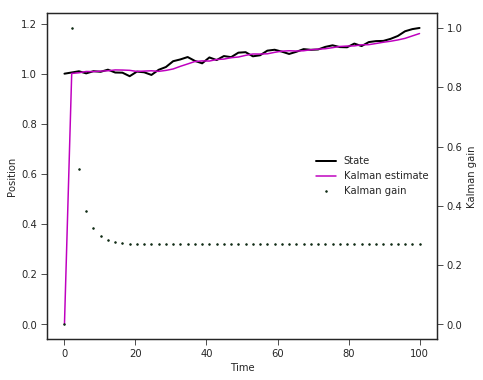

In [7]:
## test conventional kalman filter
kalman = neurkal.KalmanFilter(M=M, B=B, Z=Z)
# initial state
state = neurkal.StateDynamics(M, B, Z, x0=d_th[0])
# sensory noise
sensory_variance = 0.001

states = []
estimates = []
gains = []
for t in ts:
    estimates.append(kalman.estimate[0, 0])
    gains.append(kalman.gain[0, 0])
    states.append(state.x[0])
    x_s = state.x + np.random.normal(0, sensory_variance)
    kalman.step(c, x_s, Q=[[sensory_variance]])
    state.update(c)

palette = set_palette()
fig, ax1 = plt.subplots(figsize=(7, 6))
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
p1, = ax1.plot(ts, states, '-', color=next(palette), label="State", lw=2)
p2, = ax1.plot(ts, estimates, '-', color='m', label="Kalman estimate", markerfacecolor='none', ms=8)
ax2 = ax1.twinx()
ax2.set_ylabel("Kalman gain")
p3, = ax2.plot(ts, gains, '.', color=next(palette), label="Kalman gain", ms=3)

ps = [p1, p2, p3]
labels = [p.get_label() for p in ps]
ax1.legend(ps, labels, loc=7)
plt.show()

In [8]:
def input_act(x, x_i):
    return 3 * (np.exp(2 * (np.cos(np.deg2rad(x - x_i)) - 1)) + 0.01)

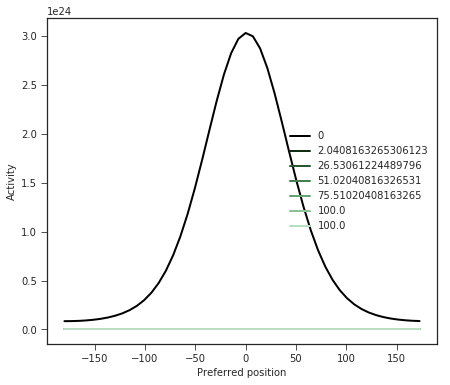

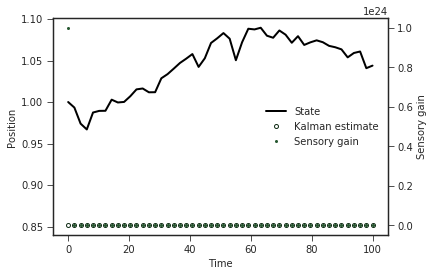

In [31]:
## Kalman network test -- only initial feedback
# initial state
state = neurkal.StateDynamics(M, B, Z, x0=d_th[0])

# network initialization
sensory_input = neurkal.PopCode(p, space=th_r, act_func=input_act,
                                dist=np.random.poisson)
# motor_input = popcode.PopCode(p, act_func=input_act, dist=lambda x: x)
kalman_network = neurkal.KalmanBasisNetwork(sensory_inputs=[sensory_input], sigma=[1e12],
                                            motor_inputs=[], M=M, B=B)

inputs = []
activities = []
states = []
estimates = []
gains = []

sensory_input(state.x[0], certain=True)
#print("cr bound: ", sensory_input.cr_bound)
for i, t in enumerate(ts):
    inputs.append(np.copy(sensory_input.activity))
    states.append(state.x[0])
    # update activity in basis network implementing Kalman filter
    kalman_network.update()
    gains.append(kalman_network.lam[0])
    estimates.append(kalman_network.estimate)
    activities.append(np.copy(kalman_network.activity))
    # update real state (+ control noise)
    state.update(c)
    if not t:
        sensory_input.clear()

prefs = kalman_network.prefs
    
palette = set_palette()
fig, ax1 = plt.subplots(figsize=(7, 6))
ax1.set_xlabel("Preferred position")
ax1.set_ylabel("Activity")
plots = 5
ps = []
ps.append(ax1.plot(prefs, activities[0], '-', color=next(palette), lw=2, label="0")[0])
for i in np.linspace(1, len(ts) - 1, plots).tolist():
    ps.append(ax1.plot(prefs, activities[int(i)], '-', color=next(palette), lw=2, 
                       label=str(ts[int(i)]))[0])
ps.append(ax1.plot(prefs, activities[-1], '-', color=next(palette), lw=2, label=str(ts[-1]))[0])
    
labels = [p.get_label() for p in ps]
ax1.legend(ps, labels, loc=7)
plt.show()

palette = set_palette()
fig, ax1 = plt.subplots()#figsize=(7, 6))
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
p1, = ax1.plot(ts, states, '-', color=next(palette), label="State", lw=2)
p2, = ax1.plot(ts, estimates, '.', color=next(palette), label="Kalman estimate", markerfacecolor='none', ms=8)
ax2 = ax1.twinx()
ax2.set_ylabel("Sensory gain")
p3, = ax2.plot(ts, gains, '.', color=next(palette), label="Sensory gain", ms=4)

ps = [p1, p2, p3]
labels = [p.get_label() for p in ps]
ax1.legend(ps, labels, loc=7)
plt.show()

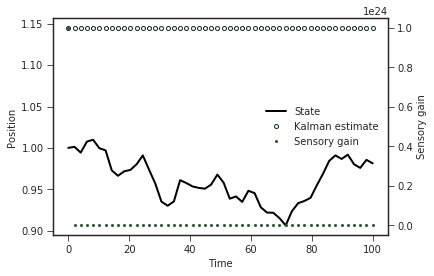

In [24]:
## Kalman network test: initial state only
# initial state
state = neurkal.StateDynamics(M, B, Z, x0=d_th[0])

# network initialization
sensory_input = neurkal.PopCode(p, space=th_r, act_func=input_act,
                                dist=np.random.poisson)
# motor_input = popcode.PopCode(p, act_func=input_act, dist=lambda x: x)
kalman_network = neurkal.KalmanBasisNetwork(sensory_inputs=[sensory_input], sigma=[1e12],
                                            motor_inputs=[], M=M, B=-np.array(B))

states = []
estimates = []
gains = []

sensory_input(d_th[0], certain=True)
for i, t in enumerate(ts):
    states.append(state.x[0])
    # update activity in basis network implementing Kalman filter
    kalman_network.update()
    gains.append(kalman_network.lam[0])
    estimates.append(kalman_network.estimate)
    # update real state (+ control noise)
    state.update(c)
    if not t:
        sensory_input.clear()
    
palette = set_palette()
fig, ax1 = plt.subplots()#figsize=(7, 6))
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
p1, = ax1.plot(ts, states, '-', color=next(palette), label="State", lw=2)
p2, = ax1.plot(ts, estimates, '.', color=next(palette), label="Kalman estimate", markerfacecolor='none', ms=8)
ax2 = ax1.twinx()
ax2.set_ylabel("Sensory gain")
p3, = ax2.plot(ts, gains, '.', color=next(palette), label="Sensory gain", ms=4)

ps = [p1, p2, p3]
labels = [p.get_label() for p in ps]
ax1.legend(ps, labels, loc=7)
plt.show()

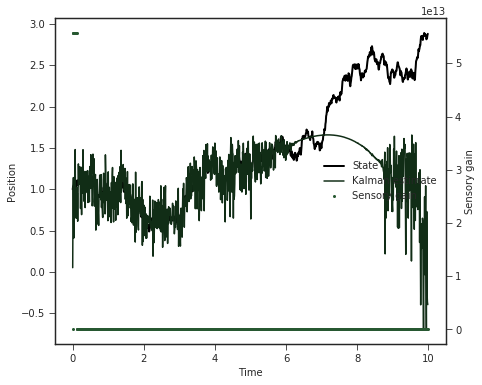

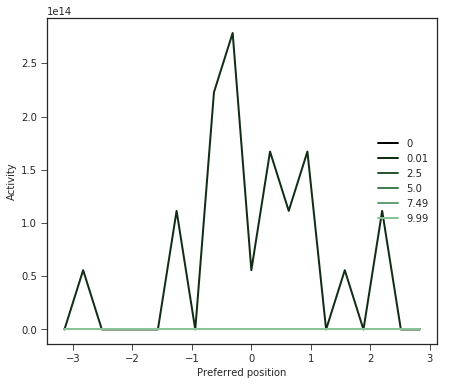

In [128]:
## Kalman network test: state estimates at each timestep
# initial state
x0 = 1
state = neurkal.StateDynamics(M, B, Z, x0=x0)

# network initialization
sensory_input = neurkal.PopCode(p, act_func=input_act,
                                dist=np.random.poisson)
# motor_input = popcode.PopCode(p, act_func=input_act, dist=lambda x: x)
kalman_network = neurkal.KalmanBasisNetwork(sensory_inputs=[sensory_input],
                                            motor_inputs=[], M=M, B=-np.array(B))

states = []
activities = []
estimates = []
gains = []

ts = np.arange(0, t_f, dt)
sensory_input(0.0)  # prior
for i, t in enumerate(ts):
    states.append(state.x[0])
    activities.append(np.copy(kalman_network.activity))
    network_estimate = kalman_network.readout()
    estimates.append(network_estimate)
    gains.append(kalman_network.lam[0])
    # update activity in basis network implementing Kalman filter
    sigma = np.var(estimates[-10:]) if i > 10 else 1e12
    kalman_network.update([[sigma]])
    
    # update real state (+ control noise)
    state.update(c_)
    sensory_input(state.x[0])
    
    
palette = set_palette()
fig, ax1 = plt.subplots(figsize=(7, 6))
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
p1, = ax1.plot(ts, states, '-', color=next(palette), label="State", lw=2)
p2, = ax1.plot(ts, estimates, '-', color=next(palette), label="Kalman estimate", markerfacecolor='none', ms=8)
ax2 = ax1.twinx()
ax2.set_ylabel("Sensory gain")
p3, = ax2.plot(ts[11:], gains[11:], '.', color=next(palette), label="Sensory gain", ms=4)

ps = [p1, p2, p3]
labels = [p.get_label() for p in ps]
ax1.legend(ps, labels, loc=7)
plt.show()

prefs = kalman_network.prefs
    
palette = set_palette()
fig, ax1 = plt.subplots(figsize=(7, 6))
ax1.set_xlabel("Preferred position")
ax1.set_ylabel("Activity")
ps = []
ps.append(ax1.plot(prefs, activities[0], '-', color=next(palette), lw=2, label="0")[0])
for i in np.linspace(1, int(t_f/dt) - 1, 5).tolist():
    ps.append(ax1.plot(prefs, activities[int(i)], '-', color=next(palette), lw=2, 
                       label=str(ts[int(i)]))[0])
    
labels = [p.get_label() for p in ps]
ax1.legend(ps, labels, loc=7)
plt.show()

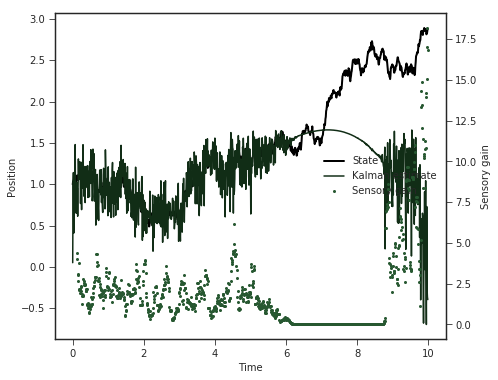

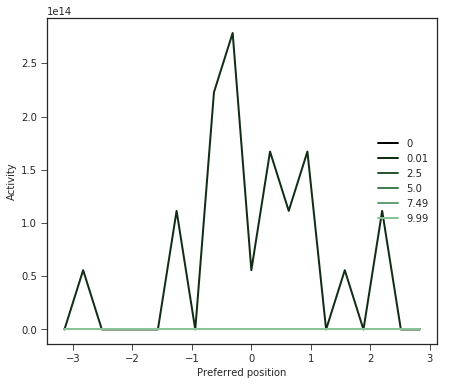

In [131]:
palette = set_palette()
fig, ax1 = plt.subplots(figsize=(7, 6))
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
p1, = ax1.plot(ts, states, '-', color=next(palette), label="State", lw=2)
p2, = ax1.plot(ts, estimates, '-', color=next(palette), label="Kalman estimate", markerfacecolor='none', ms=8)
ax2 = ax1.twinx()
ax2.set_ylabel("Sensory gain")
p3, = ax2.plot(ts[12:], gains[12:], '.', color=next(palette), label="Sensory gain", ms=4)

ps = [p1, p2, p3]
labels = [p.get_label() for p in ps]
ax1.legend(ps, labels, loc=7)
plt.show()

prefs = kalman_network.prefs
    
palette = set_palette()
fig, ax1 = plt.subplots(figsize=(7, 6))
ax1.set_xlabel("Preferred position")
ax1.set_ylabel("Activity")
ps = []
ps.append(ax1.plot(prefs, activities[0], '-', color=next(palette), lw=2, label="0")[0])
for i in np.linspace(1, int(t_f/dt) - 1, 5).tolist():
    ps.append(ax1.plot(prefs, activities[int(i)], '-', color=next(palette), lw=2, 
                       label=str(ts[int(i)]))[0])
    
labels = [p.get_label() for p in ps]
ax1.legend(ps, labels, loc=7)
plt.show()

<function matplotlib.pyplot.show>

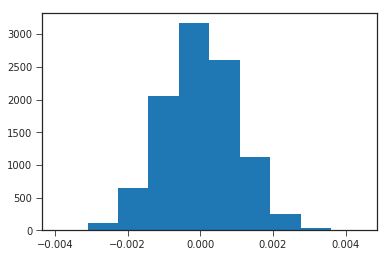